<a href="https://colab.research.google.com/github/Maarten30/ML/blob/main/dog_breed_classfication_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification 🐶 🐾

This notebook builds and end-to-end multi-class image classifier using Pytorch.


## 1. Problem

Identifying the breed of a dog given an image of a dog.


## 2. Data

The data used is from Kaggle's dog bread identification competition.

https://www.kaggle.com/c/dog-breed-identification/data


## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels)

## Imports

In [ ]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from torchvision import datasets, models, transforms

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
from IPython.display import Image as Image1
from skimage import io, transform
from PIL import Image

from sklearn.preprocessing import MultiLabelBinarizer

## Set Device

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Getting our data ready (turning into Tensors)

### Some relevant global variables

In [ ]:
# Path to training images folder
IMG_PATH = 'drive/MyDrive/Google Colab Data/Dog Vision/train/'

# Image file extension
IMG_EXT = '.jpg'

# Path to data csv
TRAIN_DATA = 'drive/MyDrive/Google Colab Data/Dog Vision/labels.csv'

# Path to test images folder
TEST_IMG_PATH = 'drive/MyDrive/Google Colab Data/Dog Vision/test/'

# Path to the folder where we will save or training outcomes
SAVING_PATH = 'drive/MyDrive/Google Colab Data/Dog Vision Pytorch/models/'

### Organizing labels and filenames 

In [ ]:
labels_csv = pd.read_csv(TRAIN_DATA)

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,b7859bc0940bcff3bcd02155742ec4be,scottish_deerhound
freq,1,126


In [ ]:
# Create pathnames from image ID's
# (Create a list of filenames)
filenames = [IMG_PATH + fname + ".jpg" for fname in labels_csv["id"]]

# Check first 10
filenames[:10]

['drive/MyDrive/Google Colab Data/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check wether number of filenames matches number of actual image files
if len(os.listdir("drive/MyDrive/Google Colab Data/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


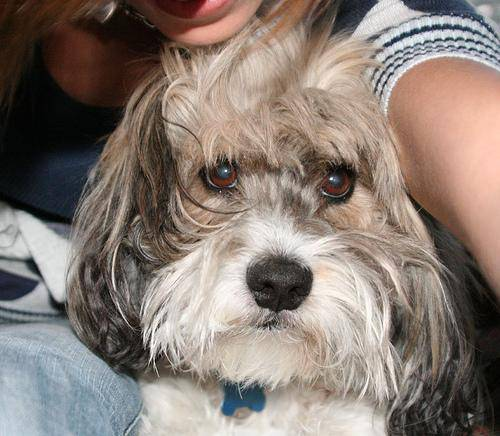

In [ ]:
# One more check
Image1(filenames[900])

In [ ]:
# Label for this specific dog
labels_csv["breed"][900]

'lhasa'

In [ ]:
# numpy array with the "breed" column of the csv file
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# See if numbers of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames


In [ ]:
# Create a numpy array with unique dog breeds
unique_breeds = np.unique(labels)
len(unique_breeds)

120

### Define image transformations

In [ ]:
# Values for Normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

If we wanted to do different transforms depending on the dataset, we could do it like this:

In [ ]:
# Image Transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]), 

    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

But as in this case, we are going to apply the same transforms to all the data, we can unify this in one.

In [ ]:
# General transform
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

### Custom Dataset class

We turn the labels into arrays, where the position of the corresponding label in the `unique_breeds` array is set to `True`


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
lhasa


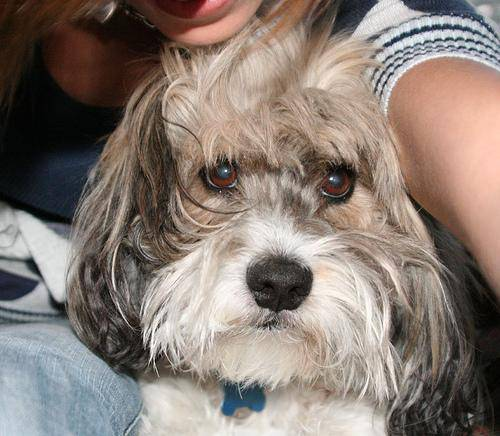

In [ ]:
# Create boolean_labels
boolean_labels = [label == unique_breeds for label in labels]

# Example
print(boolean_labels[900])
# At index 70 there is a True, and that position in the unique_breeds array
# corresponds to the breed 'lhasa'
print(unique_breeds[70])
# If we look at the dog, it matches
Image1(filenames[900])

In [ ]:
# Convert boolean_labels into a numpy array
aux = np.array(boolean_labels)
print(len(aux))

# Convert the boolean arrays into int arrays
int_labels = aux.astype(int)

# Check everything went as expected
print(int_labels[0])
print(len(int_labels))

# Find the index of the highest value
int_labels[0].argmax()

10222
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
10222


19

We must define some important parameters:



In [ ]:
# Hyperparameters
in_channel = 3
num_classes = len(unique_breeds)
learning_rate = 1e-3
batch_size = 32
num_epochs = 25

We create a custom Dataset:

In [ ]:
class DogVisionDataset(Dataset):
  def __init__(self, filenames, int_labels, transform=None):
    self.filenames = filenames
    self.int_labels = int_labels
    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, index):
    # making random_split compatible
    if torch.is_tensor(index):
      index = index.tolist()
    
    image = Image.open(self.filenames[index])
    y_label = torch.tensor(self.int_labels[index].argmax())

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [ ]:
X_dataset = DogVisionDataset(filenames=filenames, int_labels=int_labels, transform=data_transforms['train'])

In [ ]:
len(X_dataset)

10222

In [ ]:
train_dataset_size = int(len(X_dataset) * 0.8)
val_dataset_size = len(X_dataset) - train_dataset_size

In [ ]:
# separate into training set and validation set
train_set, val_set = torch.utils.data.random_split(X_dataset, (train_dataset_size, val_dataset_size))

In [ ]:
# Create DataLoaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size)

In [ ]:
# See one example
images, labels = next(iter(train_loader))
# first image in batch
print(images[0])
# first label in batch
print(labels[0])

tensor([[[-1.0219, -1.0219, -0.7993,  ...,  0.1083,  0.2967,  0.3481],
         [-0.7993, -1.0219, -1.0562,  ...,  0.4679,  0.2796, -0.1314],
         [-0.5596, -0.5253, -0.5253,  ...,  0.6392,  0.2967,  0.3309],
         ...,
         [ 2.0948,  2.0092,  1.8379,  ...,  0.5022,  0.3652, -0.0116],
         [ 1.7694,  1.8379,  1.6838,  ...,  0.2796, -0.1486,  0.2111],
         [ 1.6838,  1.8037,  1.6324,  ...,  0.4851,  0.2624, -0.1828]],

        [[-0.8102, -0.7752, -0.5126,  ...,  0.1877,  0.3627,  0.3803],
         [-0.6352, -0.8452, -0.8627,  ...,  0.5203,  0.3102, -0.1099],
         [-0.4251, -0.3725, -0.3725,  ...,  0.6954,  0.3277,  0.3452],
         ...,
         [ 2.1660,  2.1134,  1.9909,  ...,  0.2752,  0.1352, -0.2150],
         [ 1.7983,  1.9034,  1.8158,  ...,  0.0301, -0.4426, -0.0749],
         [ 1.6758,  1.8333,  1.7108,  ...,  0.1527, -0.1099, -0.6001]],

        [[-0.4798, -0.4275, -0.1661,  ...,  0.1476,  0.3393,  0.3916],
         [-0.3578, -0.5495, -0.5670,  ...,  0

### Second Custom DataSet class - Kaggle inspired

After investigation more, found an interesting kaggle resource to create nice custom Datasets.

https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning

In [ ]:
class KaggleDataSet(Dataset):
  """
  Arguments:
      A CSV file path
      Path to image folder
      Extension of images
      PIL transforms
  """

  def __init__(self, csv_path, img_path, img_ext, transform=None):

    tmp_df = pd.read_csv(csv_path)
    assert tmp_df['id'].apply(lambda x: os.path.isfile(img_path + x + img_ext)
          ).all(), \
          "Some images referenced in the csv file were not found"
    
    self.mlb = MultiLabelBinarizer()
    self.img_path = img_path
    self.img_ext = img_ext
    self.transform = transform

    self.X_train = tmp_df['id']
    self.y_train = self.mlb.fit_transform(tmp_df['breed'].str.split()).astype(np.float32)

  def __getitem__(self, index):
    img = Image.open(self.img_path + self.X_train[index] + self.img_ext)
    img = img.convert('RGB')
    if self.transform is not None:
      img = self.transform(img)
    # since we are using nn.CrossEntropyLoss, and the target has to be
    # a single number from the interval [0, #classes], we do the following:
    label = torch.tensor(self.y_train[index].argmax())
    return img, label

  def __len__(self):
    return len(self.X_train.index)

In [ ]:
kaggle_dset = KaggleDataSet(TRAIN_DATA, IMG_PATH, IMG_EXT, transform)

In [ ]:
# dset sizes
kaggle_train_dset_size = int(len(kaggle_dset) * 0.8)
kaggle_val_dset_size = len(kaggle_dset) - kaggle_train_dset_size

In [ ]:
# separate into training set and validation set
kaggle_train_dset, kaggle_val_dset = torch.utils.data.random_split(kaggle_dset, (kaggle_train_dset_size, kaggle_val_dset_size))

In [ ]:
# create the dataloaders
kaggle_data_loaders = {
    'train': DataLoader(kaggle_train_dset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(kaggle_val_dset, batch_size=batch_size)
}

### Custom Dataset class for unlabled data

At the end, we will want to create a dataset of unlabled data in order to make predictions of images that don't have labels. Therefore we will create another custom class. 

In [ ]:
class UnlabledDataset(Dataset):
  """
  Arguments:
      Array of paths to img files
      PIL transforms
  """

  def __init__(self, filenames, transform=None):

    self.filenames = filenames
    self.transform = transform

  def __getitem__(self, index):
    # making random_split compatible
    if torch.is_tensor(index):
      index = index.tolist()

    img = Image.open(self.filenames[index])
    img = img.convert('RGB')
    if self.transform is not None:
      img = self.transform(img)

    return img

  def __len__(self):
    return len(self.filenames)

### Creating an experimental DataSet

As the dataset is quite large, and we still don't know if everything is going to work correctly, we are going to create a smaller dataset to experiment on it and make sure everything is working fine.

For that we will:

1. Take only 1000 images and their labels.
2. Create a `small_dataset` with our custom `DogVisionDataset`.
3. Divide this just created `small_dataset`, into a `small_train_set` and a `small_test_set`.
4. Divide this just created `small_train_set`, into an actual `train_subset` and a `val_subset` set. 


In [ ]:
# Size of the complete Dataset
print(len(filenames)) # img_paths
print(len(int_labels)) # labels

10222
10222


In [ ]:
# Let's take just a 1000 images
small_filenames = filenames[:1000]
small_int_labels = int_labels[:1000]

In [ ]:
small_dataset = DogVisionDataset(filenames=small_filenames, int_labels=small_int_labels, transform=transform)

In [ ]:
# Let's divide the data into train and test datasets
# First we declare the sizes of the train and test datasets
small_dataset_train_size = int(len(small_dataset) * 0.9)
small_dataset_test_size = len(small_dataset) - small_dataset_train_size

In [ ]:
print(small_dataset_train_size)
print(small_dataset_test_size)

900
100


In [ ]:
# Now we divide the dataset
small_train_set, small_test_set = torch.utils.data.random_split(small_dataset, (small_dataset_train_size, small_dataset_test_size))

In [ ]:
# Let's check their sizes
print(len(small_train_set))
print(len(small_test_set))

900
100


In [ ]:
# Now let's divide the train set, into train set and val set
# Firs, we declare again the sizes of both datasets
train_subset_size = int(len(small_train_set) * 0.8)
val_subset_size = len(small_train_set) - train_subset_size

In [ ]:
print(train_subset_size)
print(val_subset_size)

720
180


In [ ]:
# Now we do the actual division
train_subset, val_subset = torch.utils.data.random_split(small_train_set, (train_subset_size, val_subset_size))

In [ ]:
# Check their sizes
print(len(train_subset))
print(len(val_subset))

720
180


In [ ]:
# Data Loaders for the small dataset
small_data_loaders = {
    'train': torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(val_subset, batch_size=batch_size),
    'test': torch.utils.data.DataLoader(small_test_set, batch_size=batch_size)
}

## Building a Model

### Define input and output shape

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [3, 224, 224]

# Setup output shape to the model
OUTPUT_SHAPE = len(unique_breeds)

### Function to create a resnet18 model

In [ ]:
def create_resnet18_model(output_size, pretrained=True):
  """
  function to create a resnet18 model
  """
  
  model = models.resnet18(pretrained=pretrained)
  
  for param in model.parameters():
    param.requires_grad = False

  num_ftrs = model.fc.in_features
  # define the size of the input and output samples
  model.fc = nn.Linear(num_ftrs, output_size)

  return model

## Define train and test functions

### Train Function

The `train()` function **must receive**:

* `model`: The model we want to train.
* `dataloaders`: Object with 2 `DataLoaders`, one with a `train` `DataLoader` and another one with a `val` `DataLoader`.
* `criterion`:
* `optimizer`:
* `num_epochs`: number of times we want to iterate through the complete dataset. Default set to 25.


In [ ]:
def train(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False): 
  """
  returns a trained model
  """
  since = time.time()

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
  
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0


      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          # Special case for inception because in training it has an auxiliary output. In train
          #   mode we calculate the loss by summing the final output and the auxiliary output
          #   but in testing we only consider the final output.
          if is_inception and phase == 'train':
            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2
          else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
          
          _, preds = torch.max(outputs, 1)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_acc_history.append(epoch_acc)
    
    print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  
  return model, val_acc_history

### Test Function

The `test()` function **must receive**:

* `model`: The model we want to train.
* `dataloaders`: Object with a `test` `DataLoaders` 
* `criterion`:


In [ ]:
def test(model, dataloaders, criterion):

  # monitor test loss and accuracy
  test_loss = 0.
  correct = 0.
  total = 0.

  model.eval()
  for batch, (data, target) in enumerate(dataloaders['test']):
    print('Batch: {} / {}'.format(batch, len(dataloaders['test'])))
    
    # move to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss
    test_loss = test_loss + ((1 / (batch + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

  print('Test Loss: {:.6f}\n'.format(test_loss))
  print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

## Testing the train and test functions

### Training on a subset of the data

In [ ]:
# Create the model and move it to the device
model = create_resnet18_model(OUTPUT_SHAPE, pretrained=True)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Create a criterion
criterion = nn.CrossEntropyLoss()

Remember **this could take a while!**

In [ ]:
# Let's train the model
trained_model = train(model, small_data_loaders, criterion, optimizer, num_epochs=num_epochs)

### Test the trained model

In [ ]:
# Now let's test the model
model_to_test, acc_info = trained_model
test(model_to_test, small_data_loaders, criterion)

After training the model, we have achieved an accuracy of 43%. This is very low, but at the same time it was expected as we only trained the model on approximately 1/10 of the data.

## Save Trained Models

### Saving Model Example

In [ ]:
model_to_save, acc_history = trained_model

In [ ]:
print(model_to_save)
print(acc_history)

In [ ]:
torch.save({
    'model_state_dict': model_to_save.state_dict(),
    'acc_history': acc_history
 }, 'drive/MyDrive/Google Colab Data/Dog Vision Pytorch/models/small_data_training_checkpoint.pth')


### Saving Model Function

In [ ]:
def save_model(model, filename, extra_info_to_save=None):
  checkpoint = {
      'model_state_dict': model.state_dict(),
  }

  if extra_info_to_save:
    checkpoint.update(extra_info_to_save)
  
  path = os.path.join(SAVING_PATH, filename)

  torch.save(checkpoint, path)

  return "Model and it's data saved correctly"

In [ ]:
# Test the method
extra_info = {
    'acc_history': acc_history
}

filename = 'small_data_training_checkpoint_2.pth'

save_model(model_to_save, filename, extra_info_to_save=extra_info)

"Model and it's data saved correctly"

## Load Trained Models

### Loading model Example

In [ ]:
# Create a resnet model
loaded_model = create_resnet18_model(OUTPUT_SHAPE, pretrained=True)

In [ ]:
# Load Checkpoint
checkpoint = torch.load('drive/MyDrive/Google Colab Data/Dog Vision Pytorch/models/small_data_training_checkpoint.pth')

In [ ]:
loaded_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
loaded_model.eval()

### Loading Model Function

In [ ]:
def load_resnet18_model(path):
  """
  Loads a trained resnet18 model
  """
  # Create a model
  model = create_resnet18_model(OUTPUT_SHAPE, pretrained=True)

  # Load checkpoint
  checkpoint = torch.load(path)

  # Load state dict in the model, from checkpoint
  model.load_state_dict(checkpoint['model_state_dict'])

  # Put the model in eval mode
  model.eval()

  return model

In [ ]:
# Test the function
loaded_model_example = load_resnet18_model('drive/MyDrive/Google Colab Data/Dog Vision Pytorch/models/small_data_training_checkpoint_2.pth')

In [ ]:
loaded_model_example

## Training the model on the full dataset

Now that we have tested that everything is working and that our functions to train work correctly, we can train a model on the full dataset.

For this we are going to use or function `train()` and our `KaggleDataset`

### Create a resnet18 model

In [ ]:
# Create a model
base_model = create_resnet18_model(OUTPUT_SHAPE, pretrained=True)

# Move it to cuda
base_model.to(device)

### Create an Adam Optimizer

In [ ]:
# Create an optimizer
optimizer = torch.optim.Adam(base_model.parameters(), lr=learning_rate)

### Create a Criterion

In [ ]:
# Create a criterion
criterion = nn.CrossEntropyLoss()

### Check the dataloaders

In [ ]:
# Check our data loaders are still active
image, label = next(iter(kaggle_data_loaders['train']))

In [ ]:
label[0]

tensor(19)

### Train the model

In [ ]:
# Train the model!!
complete_training_outcome = train(base_model, kaggle_data_loaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 2.6484 Acc: 0.4385
val Loss: 1.3986 Acc: 0.6826

Epoch 1/24
----------
train Loss: 1.1419 Acc: 0.7324
val Loss: 1.0180 Acc: 0.7218

Epoch 2/24
----------
train Loss: 0.8367 Acc: 0.7926
val Loss: 0.9274 Acc: 0.7315

Epoch 3/24
----------
train Loss: 0.6946 Acc: 0.8217
val Loss: 0.8710 Acc: 0.7355

Epoch 4/24
----------
train Loss: 0.5974 Acc: 0.8463
val Loss: 0.8340 Acc: 0.7491

Epoch 5/24
----------
train Loss: 0.5134 Acc: 0.8674
val Loss: 0.8223 Acc: 0.7487

Epoch 6/24
----------
train Loss: 0.4656 Acc: 0.8821
val Loss: 0.8035 Acc: 0.7443

Epoch 7/24
----------
train Loss: 0.4042 Acc: 0.8978
val Loss: 0.8157 Acc: 0.7487

Epoch 8/24
----------
train Loss: 0.3794 Acc: 0.9044
val Loss: 0.8277 Acc: 0.7487

Epoch 9/24
----------
train Loss: 0.3371 Acc: 0.9176
val Loss: 0.8205 Acc: 0.7433

Epoch 10/24
----------
train Loss: 0.3123 Acc: 0.9234
val Loss: 0.8464 Acc: 0.7443

Epoch 11/24
----------
train Loss: 0.2922 Acc: 0.9286
val Loss: 0.8262 Acc: 0.7457

Ep

### Save the trained model

In [ ]:
# Definde the filename
fully_trained_model_filename = 'full-image-set-resnet18-Adam.pth'

In [ ]:
# Get the model and the accuracy history
fully_trained_model, acc_history = complete_training_outcome

In [ ]:
# Insert the accuracy history in an object
extra_info = {
    'acc_history': acc_history
}

In [ ]:
# Save the model
save_model(fully_trained_model, fully_trained_model_filename, extra_info_to_save=extra_info)

"Model and it's data saved correctly"

## Get Prediction Probabilities

Now that we are able to train and test our models, let's create a way of visualizing what the predicition probailities are for each dog breed.

### Experimentation

This part is pure experimentation, in order to later on create a function to make predictions and get probabilites.

In [ ]:
# Load the model
loaded_model = load_resnet18_model('drive/MyDrive/Google Colab Data/Dog Vision Pytorch/models/full-image-set-resnet18-Adam.pth')

In [ ]:
data, target = next(iter(kaggle_data_loaders['train']))

In [ ]:
len(data)

32

In [ ]:
output = loaded_model(data)

In [ ]:
# output from crossentropy score
output[0]

tensor([-22.0679, -19.2470, -23.5163, -11.3924, -12.9433,  -5.5234, -19.9652,
        -10.6573, -13.1252, -11.9021, -21.7089, -17.1716,  -0.4571, -20.6222,
        -10.7436,  -9.4436, -10.2243, -15.1115, -16.0240, -16.0513, -20.7683,
        -17.3220, -16.2210, -22.9213, -15.7518, -13.7633, -23.0146, -15.6172,
        -11.6090, -11.9410, -21.1222, -17.8094, -18.9998, -13.6170, -10.0857,
        -22.0746, -23.0958, -13.2939,  -7.2900, -18.8254, -17.4522, -19.6101,
         -7.2065, -14.8833,  -5.5231, -19.6319, -10.7132, -13.8237, -14.4351,
        -15.8287, -12.6056,  -8.2592, -16.3895,  -3.8502, -18.0382, -17.6260,
        -19.8188, -16.2757, -18.9079, -13.2705, -11.7195, -25.1753, -21.6859,
         -7.8087, -19.0902, -23.9254, -17.0784,  -2.9774, -15.7022, -18.3808,
        -21.6359, -15.3849, -12.6954, -18.7515, -22.4136, -11.2591, -17.6832,
        -18.1855, -15.3581, -22.8052, -12.3247, -19.7023, -21.2996, -18.1518,
        -22.3381, -21.2182, -17.4384, -23.3379, -12.2380,  -8.77

In [ ]:
len(output[0])

120

In [ ]:
len(unique_breeds)

120

In [ ]:
sm = torch.nn.Softmax()
probabilities = sm(output)
# Converted to probabilities
print(sum(probabilities[0].detach().numpy()))
print(sum(probabilities[0]))

1.0000000096492605
tensor(1.0000, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
# Check probabilites add up to 1
sum(probabilities[0])

tensor(1.0000, grad_fn=<AddBackward0>)

In [ ]:
probabilities[0].argmax()

tensor(106)

The model's prediction was:

In [ ]:
unique_breeds[64]

'kerry_blue_terrier'

And out input image was:

In [ ]:
data.shape

torch.Size([32, 3, 224, 224])

In [ ]:
image = data[0]

In [ ]:
image = image.permute(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


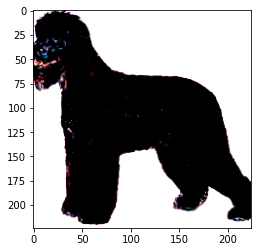

In [ ]:
plt.imshow(image)

In [ ]:
target[0].argmax()

tensor(58)

In [ ]:
unique_breeds[58]

'irish_water_spaniel'

**Result** of the test:
* The breed the model predicted is:
  * kerry_blue_terrier
* But the target was: 
  * irish_water_spaniel

And an irish_water_spaniel looks something like:

In [ ]:
print(labels_csv[labels_csv['breed'] == 'irish_water_spaniel'])

                                     id                breed
27     00b7d114bc5166a629a3cc03d9329120  irish_water_spaniel
41     011bd7fd7c036dbb243d0e37329c77b7  irish_water_spaniel
51     0159b6457aac89f43d1c1931cdf7500b  irish_water_spaniel
53     015b4aa50dd9b4a0d26dc0c38f41b489  irish_water_spaniel
319    07b5288a0bb8b9cf1a42d281a9451e51  irish_water_spaniel
...                                 ...                  ...
9439   ecccfab92b35ee51d1896eb35f5379a7  irish_water_spaniel
9511   ee64bb93cf0e12fc0549b89083f9347b  irish_water_spaniel
9547   ef608e79d3e91f00896e2584c66a1709  irish_water_spaniel
9827   f750daa88a8129fd8af9e6b686698147  irish_water_spaniel
10140  fdcedfa9f9ae621a4889e844b9e2940d  irish_water_spaniel

[78 rows x 2 columns]


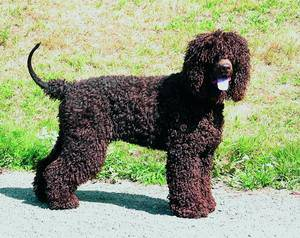

In [ ]:
Image1(filenames[9439])

So, although we can improve a lot our model by training it with the full dataset, this time it wasn't that bad 🤷🏻‍♂️ .

### Predictions Function

In [ ]:
def predict(model, dataloader):
  """
  Returns a list with the prediction probabilities for each breed,
  corresponding to each image
  """

  predictions_list = []
  sm = torch.nn.Softmax()

  for i, data in enumerate(dataloader):
    print('Batch: {}/{}'.format(i, (len(dataloader) - 1)))
    data = data.to(device)
    # make predictions of each data batch
    outputs = model(data)
    # turn the outputs into probabilites
    probabilities = sm(outputs)
    for i in range(len(probabilities)):
        predictions_list.append(probabilities[i].cpu().detach().numpy())
  
  return predictions_list

## Making predictions

### Prepare the data

In [ ]:
# Get all the filenames
test_filenames = [TEST_IMG_PATH + fname for fname in os.listdir(TEST_IMG_PATH)]
# See first 10
test_filenames[:10]

['drive/MyDrive/Google Colab Data/Dog Vision/test/ea1039f3869357b53abf4ace351218a6.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/ed61910363f37890c8cc47b25836f82e.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/eb06356375888d41903fff14ef7c4104.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/f2c4131850c17dee485d48c2bb8a358e.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/f15527e7a063275291e469b4e5db751c.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/f16cb4716034cecf3edd7260109fdf17.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/ec6b4aee97cf7eeb6cb26540af933db2.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/f1f339f43e83cfb8e4bf76ff5671489c.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/ed3d8126013933f566dc4113efe7c0bc.jpg',
 'drive/MyDrive/Google Colab Data/Dog Vision/test/f1eadf24d904d3c1e26d8081555901be.jpg']

In [ ]:
# Create the dataset
full_test_dataset = UnlabledDataset(filenames=test_filenames, transform=transform)

In [ ]:
# Create the dataloaders
test_dataloader = DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False)

### Load the model

In [ ]:
fully_trained_model = load_resnet18_model('/content/drive/MyDrive/Google Colab Data/Dog Vision Pytorch/models/full-image-set-resnet18-Adam.pth')
fully_trained_model.to(device)

### Test predictions

To check our `predict()` method is working fine, let's run it with a small part of the test dataset.

In [ ]:
experimental_test_dest_size = int(len(full_test_dataset) * 0.05)
other_size = int(len(full_test_dataset) - experimental_test_dest_size)

In [ ]:
experimental_test_dest_size

517

In [ ]:
experimental_test_dest, _ = torch.utils.data.random_split(full_test_dataset, (experimental_test_dest_size, other_size))

In [ ]:
len(experimental_test_dest)

517

In [ ]:
experimental_test_dloader = DataLoader(experimental_test_dest, batch_size=batch_size)

In [ ]:
experimental_test_predictions = predict(fully_trained_model, experimental_test_dloader)

Batch: 0/16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Batch: 1/16
Batch: 2/16
Batch: 3/16
Batch: 4/16
Batch: 5/16
Batch: 6/16
Batch: 7/16
Batch: 8/16
Batch: 9/16
Batch: 10/16
Batch: 11/16
Batch: 12/16
Batch: 13/16
Batch: 14/16
Batch: 15/16
Batch: 16/16


In [ ]:
# Sum of probabilities adds up to 1
sum(experimental_test_predictions[0])

### Predict

In [ ]:
test_predictions = predict(fully_trained_model, test_dataloader)

Batch: 0/323


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Batch: 1/323
Batch: 2/323
Batch: 3/323
Batch: 4/323
Batch: 5/323
Batch: 6/323
Batch: 7/323
Batch: 8/323
Batch: 9/323
Batch: 10/323
Batch: 11/323
Batch: 12/323
Batch: 13/323
Batch: 14/323
Batch: 15/323
Batch: 16/323
Batch: 17/323
Batch: 18/323
Batch: 19/323
Batch: 20/323
Batch: 21/323
Batch: 22/323
Batch: 23/323
Batch: 24/323
Batch: 25/323
Batch: 26/323
Batch: 27/323
Batch: 28/323
Batch: 29/323
Batch: 30/323
Batch: 31/323
Batch: 32/323
Batch: 33/323
Batch: 34/323
Batch: 35/323
Batch: 36/323
Batch: 37/323
Batch: 38/323
Batch: 39/323
Batch: 40/323
Batch: 41/323
Batch: 42/323
Batch: 43/323
Batch: 44/323
Batch: 45/323
Batch: 46/323
Batch: 47/323
Batch: 48/323
Batch: 49/323
Batch: 50/323
Batch: 51/323
Batch: 52/323
Batch: 53/323
Batch: 54/323
Batch: 55/323
Batch: 56/323
Batch: 57/323
Batch: 58/323
Batch: 59/323
Batch: 60/323
Batch: 61/323
Batch: 62/323
Batch: 63/323
Batch: 64/323
Batch: 65/323
Batch: 66/323
Batch: 67/323
Batch: 68/323
Batch: 69/323
Batch: 70/323
Batch: 71/323
Batch: 72/323
B

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed. 
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the Id column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit to Kaggle.


In [ ]:
# Create a pandas DataFrame with empty columns
predictions_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
predictions_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
# Get the test image ID's
test_ids = [os.path.splitext(path)[0] for path in os.listdir(TEST_IMG_PATH)]

In [ ]:
test_ids[:10]

['ea1039f3869357b53abf4ace351218a6',
 'ed61910363f37890c8cc47b25836f82e',
 'eb06356375888d41903fff14ef7c4104',
 'f2c4131850c17dee485d48c2bb8a358e',
 'f15527e7a063275291e469b4e5db751c',
 'f16cb4716034cecf3edd7260109fdf17',
 'ec6b4aee97cf7eeb6cb26540af933db2',
 'f1f339f43e83cfb8e4bf76ff5671489c',
 'ed3d8126013933f566dc4113efe7c0bc',
 'f1eadf24d904d3c1e26d8081555901be']

In [ ]:
# Append test image ID's to the predictions DataFrame
predictions_df['id'] = test_ids

In [ ]:
predictions_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,ea1039f3869357b53abf4ace351218a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ed61910363f37890c8cc47b25836f82e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eb06356375888d41903fff14ef7c4104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f2c4131850c17dee485d48c2bb8a358e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f15527e7a063275291e469b4e5db751c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add the prediction probabilities to each dog breed column
predictions_df[list(unique_breeds)] = test_predictions

In [ ]:
# Save our predictions dataframe to CSV for submission to Kaggle
predictions_df.to_csv("drive/MyDrive/Google Colab Data/Dog Vision Pytorch/full_model_predictions_submission_1_resnet18.csv",
                index=False)

In [ ]:
# load them to visualize
loaded_predictions_df = pd.read_csv('drive/MyDrive/Google Colab Data/Dog Vision Pytorch/full_model_predictions_submission_1_resnet18.csv')

Kaggle Score: 0.88175

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into a `UnlabledDataset`.
* Turn the `UnlabledDataset` into a `DataLoader`.
* Pass the `DataLoader` to our `predict()` function.
* Convert the prediction output probailities to prediction labels.
* Compare the predicted labels to the custom images.


In [ ]:
# Get the custom image filepaths
custom_path = "drive/MyDrive/Google Colab Data/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/MyDrive/Google Colab Data/Dog Vision/my-dog-photos/annie_2.jpeg',
 'drive/MyDrive/Google Colab Data/Dog Vision/my-dog-photos/annie_3.jpeg',
 'drive/MyDrive/Google Colab Data/Dog Vision/my-dog-photos/annie_4.jpeg',
 'drive/MyDrive/Google Colab Data/Dog Vision/my-dog-photos/annie_5.jpeg',
 'drive/MyDrive/Google Colab Data/Dog Vision/my-dog-photos/annie_1.jpeg']

In [ ]:
# Turn custom images into a Dataset
custom_img_dataset = UnlabledDataset(custom_image_paths, transform=transform)

In [ ]:
# Create dataloader
custom_img_loader = DataLoader(custom_img_dataset, batch_size=batch_size)

In [ ]:
# Load the model
fully_trained_model = load_resnet18_model('/content/drive/MyDrive/Google Colab Data/Dog Vision Pytorch/models/full-image-set-resnet18-Adam.pth')
fully_trained_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
custom_img_predictions = predict(fully_trained_model, custom_img_loader)

Batch: 0/0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turn an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
get_pred_label(custom_img_predictions[0])

'whippet'

In [ ]:
custom_pred_labels = [get_pred_label(custom_img_predictions[i]) for i in range (len(custom_img_predictions))]
custom_pred_labels

['whippet',
 'silky_terrier',
 'labrador_retriever',
 'chesapeake_bay_retriever',
 'labrador_retriever']

In [ ]:
# Get custom images
custom_images = []
for i, batch in enumerate(custom_img_loader):
  for j in range(len(batch)):
    custom_images.append(batch[j])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


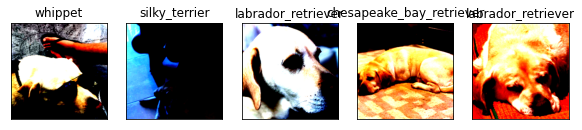

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)